## Load data

In [23]:
import numpy as np
import _pickle as pkl
import torch
from torchvision import transforms
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray
set_seed_torch(3)

In [24]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({'res': 64,
 'dataset_path': '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("visual_haptic_2D_len16_569B46785E3F45BCA172AE53EA070D5E.pkl"),
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("test2"),
 'device': 'cuda:0',
 'n_examples': 5,
 'n_predictions': 6,
})

In [25]:
with open(args.dataset_path, 'rb') as f:
    data = pkl.load(f)

imgs_rgb = torch.from_numpy(data["img"]).to(device=args.device).float()
imgs_gray = torch.from_numpy(rgb2gray(data["img"]).transpose(0, 1, 4, 2, 3)).to(device=args.device).float()
ft = torch.from_numpy(data["ft"]).to(device=args.device).float()
arm = torch.from_numpy(data["arm"]).to(device=args.device).float()
actions = torch.from_numpy(data["action"]).to(device=args.device).float()

## Visualize

In [26]:
from utils import load_models, load_vh_models, frame_stack
from argparse import Namespace
import json
import torch.nn as nn

3
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/test2/2D_bigz_gru_lm_vha
MSE of predictions:  [3.2244203 2.8252056 5.1841383 6.246045  5.992819  8.294924 ]


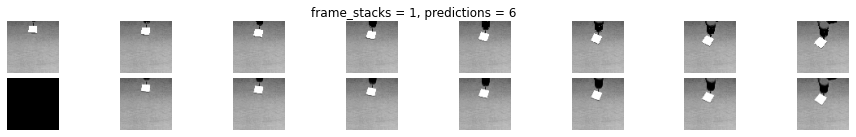

MSE of predictions:  [2.6714737 1.6564817 3.0487354 4.5894933 4.9742804 6.9623027]


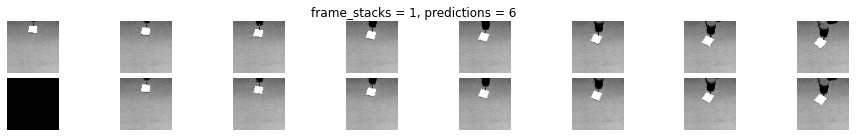

MSE of predictions:  [1.4209408 2.408863  3.4220984 5.0775743 6.530989  7.6155167]


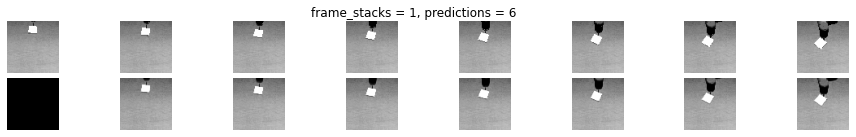

MSE of predictions:  [ 1.9714538  3.0428576  6.1973443  6.6638947  7.13125   10.890256 ]


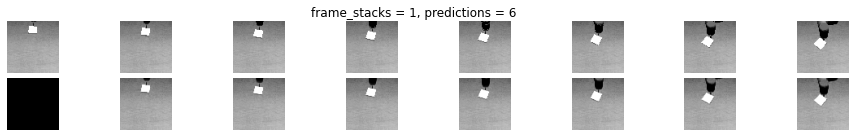

MSE of predictions:  [1.765039  1.8080454 4.4207187 3.749359  5.578316  7.7820196]


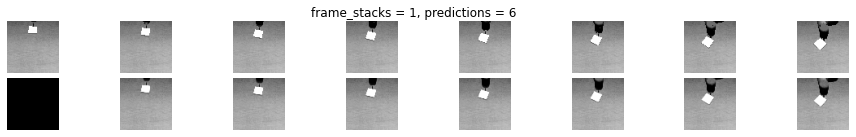

5
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/test2/2D_bigz_gru_lm_v
unexpected EOF, expected 399435 more bytes. The file might be corrupted.
unexpected EOF, expected 133558 more bytes. The file might be corrupted.
unexpected EOF, expected 642607 more bytes. The file might be corrupted.
unexpected EOF, expected 782349 more bytes. The file might be corrupted.
MSE of predictions:  [287.3794  270.73343 253.8079  254.14575 261.4773  279.7448 ]


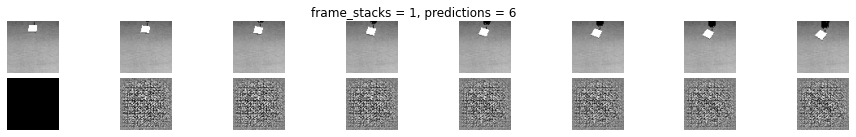

MSE of predictions:  [249.44025 238.51839 230.15193 238.88351 258.83447 290.8877 ]


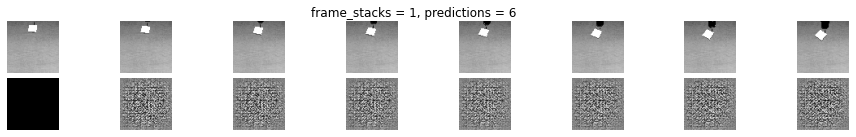

MSE of predictions:  [262.3958  252.39233 255.10902 265.2193  285.57867 312.75412]


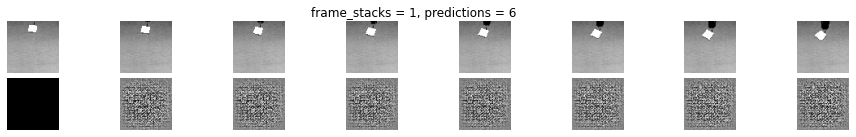

MSE of predictions:  [272.17365 257.79974 252.0617  257.7718  274.45386 297.43137]


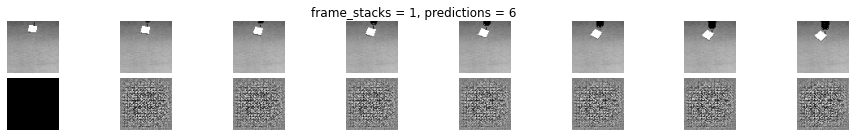

MSE of predictions:  [235.86795 222.45792 226.63264 243.57155 273.09088 310.09558]


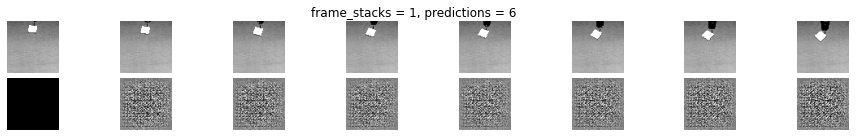

5
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/test2/2D_bigz_gru_nl_v
MSE of predictions:  [ 8.280705   2.7671027  3.1679232  4.8295717 22.867737   6.9486074]


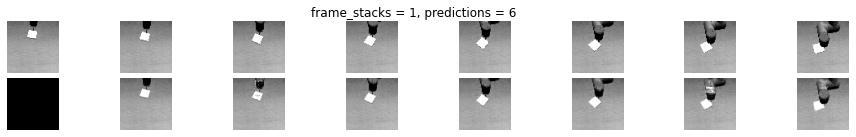

MSE of predictions:  [0.7985198 2.8762496 3.428065  4.6840644 2.688658  5.470082 ]


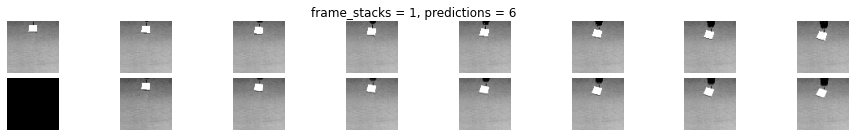

MSE of predictions:  [1.4852071 3.8453836 5.9355893 5.5983777 6.341241  7.8111486]


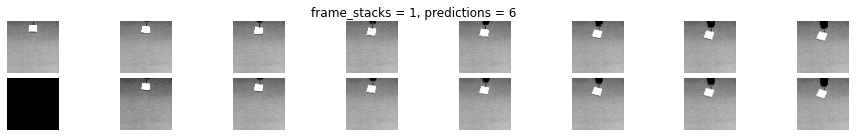

MSE of predictions:  [1.4771426 4.526914  5.638479  6.1522384 7.63375   8.780475 ]


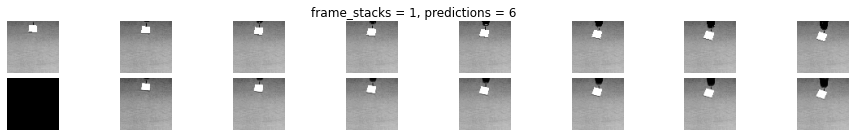

MSE of predictions:  [ 2.531144   4.4297523  8.39087    8.597544  11.390705  13.201583 ]


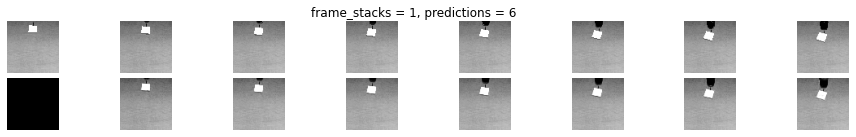

6
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/test2/2D_bigz_gru_lm_vha_4step
MSE of predictions:  [ 1.5054095  2.6648183  4.2621713  6.134204   9.634784  13.645339 ]


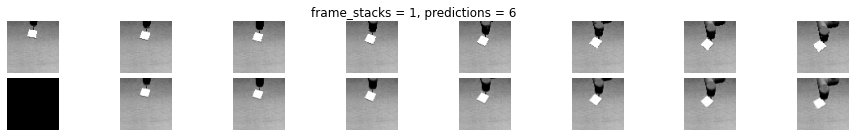

MSE of predictions:  [ 2.14199    2.3236146  3.2709947  4.9961863  8.2300415 13.789413 ]


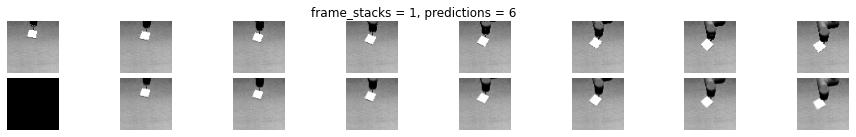

MSE of predictions:  [ 1.8763127  2.2381628  2.765236   5.0469356  7.166485  12.321009 ]


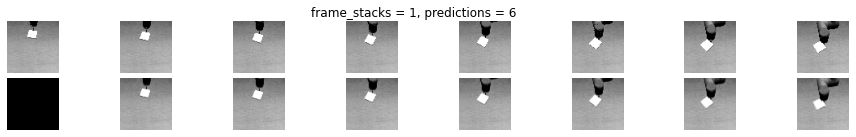

MSE of predictions:  [ 2.4960577  2.7364233  4.8580394  5.8380246  7.9920816 14.073906 ]


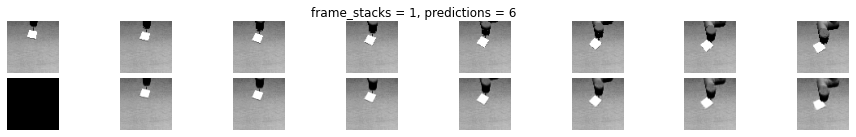

MSE of predictions:  [ 2.089347   2.0881252  3.7107816  5.427133   8.246653  10.883274 ]


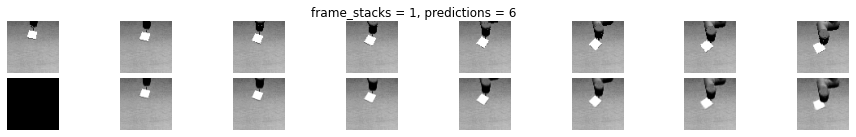

7
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/test2/2D_bigz_gru_nl_vha_4step
MSE of predictions:  [ 1.6682779  2.4850714  5.1646166  6.6484222  9.38244   14.408901 ]


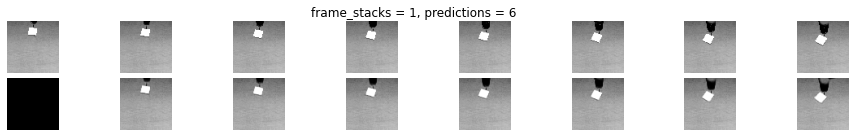

MSE of predictions:  [ 2.1285806  3.1616461  3.444984   5.550792  10.37398   14.1806965]


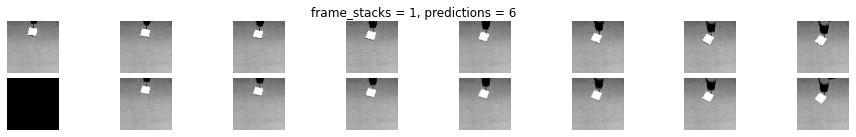

MSE of predictions:  [ 2.0855696  3.6385381  5.0079303  7.300263  11.742035  16.588676 ]


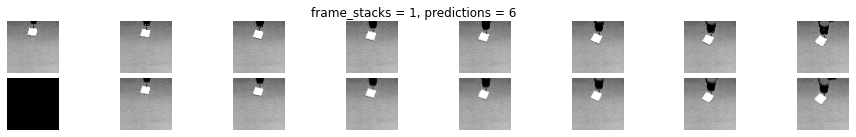

MSE of predictions:  [ 3.712201   4.1093802  4.412285   5.9571333  9.34181   17.006208 ]


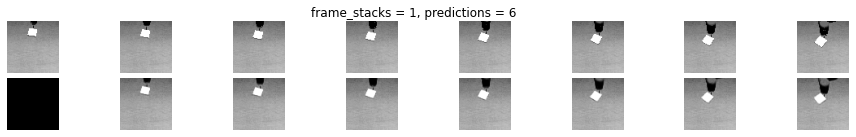

MSE of predictions:  [ 2.6996818  2.2930205  2.8922298  6.0816045  8.351334  11.581149 ]


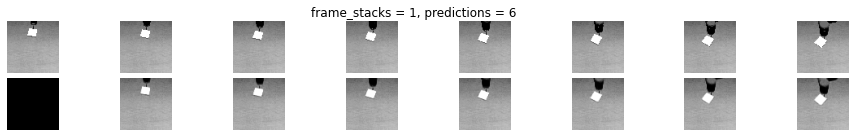

1
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/test2/2D_bigz_gru_nl_vha
MSE of predictions:  [13.615617   9.050924   9.034842   7.7108774 10.567296  11.172665 ]


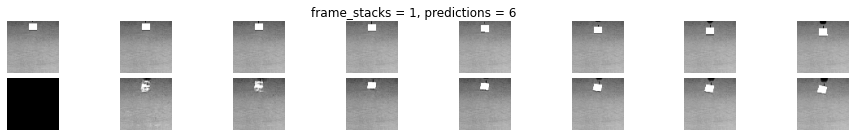

MSE of predictions:  [34.25238   19.137077   5.6205935  8.198463   8.778538  10.73672  ]


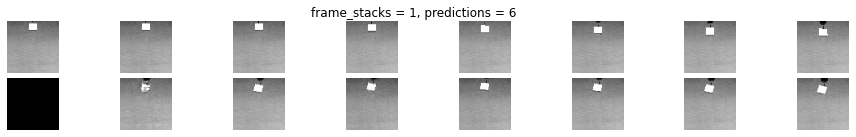

MSE of predictions:  [11.210453   6.0399     3.1854491  3.520678   7.2803636 10.056327 ]


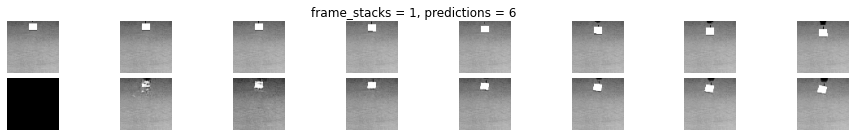

MSE of predictions:  [15.753642 14.146021 18.255342 18.776066 20.978493 22.340902]


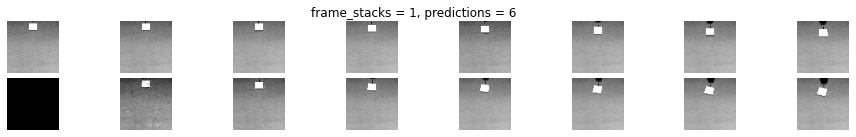

MSE of predictions:  [10.629725   7.335639  10.986584   8.639754  11.5568905 13.913509 ]


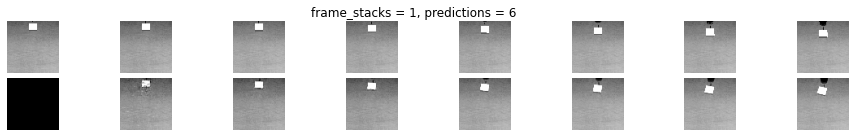

2
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/test2/2D_bigz_gru_nl_v_4step
MSE of predictions:  [ 3.6631424  6.6375723  9.226275   8.666691   9.322805  11.248077 ]


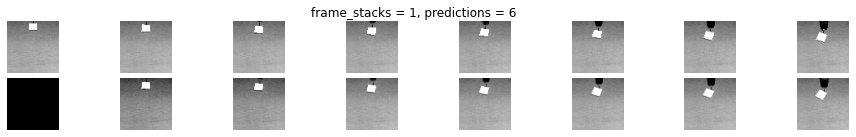

MSE of predictions:  [ 3.9155433  8.137546  10.202145  10.779368  10.223155  13.268602 ]


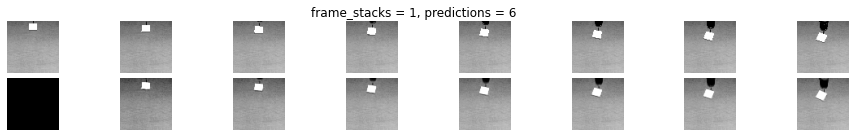

MSE of predictions:  [ 2.8406801  8.0207205  8.890936   9.393511  10.516429  11.983048 ]


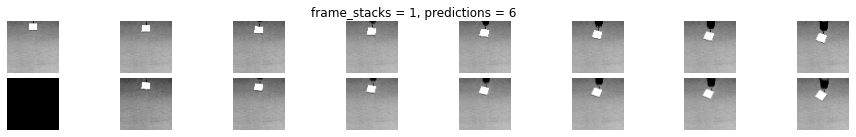

MSE of predictions:  [ 2.517712  6.752925  8.50113   9.250607 11.213786 13.17589 ]


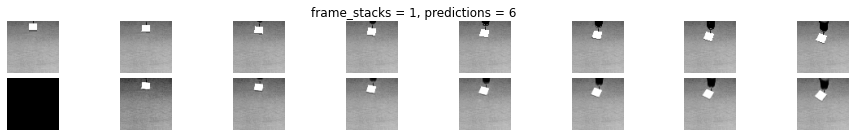

MSE of predictions:  [ 2.4576936  6.524475   8.221102   8.270866   9.627949  12.639823 ]


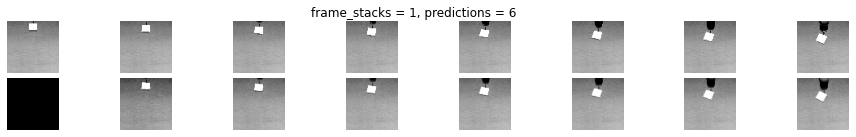

1
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/test2/2D_bigz_gru_lm_v_4step
MSE of predictions:  [6.5780153 4.1983523 4.7489552 5.8105035 4.9444504 5.5361004]


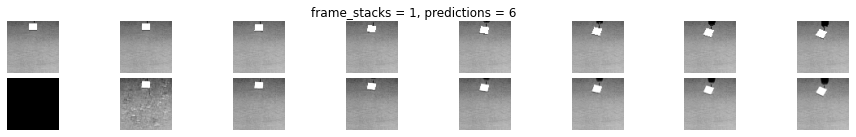

MSE of predictions:  [7.0780473 4.733319  5.0897274 5.7677813 4.124512  5.2731605]


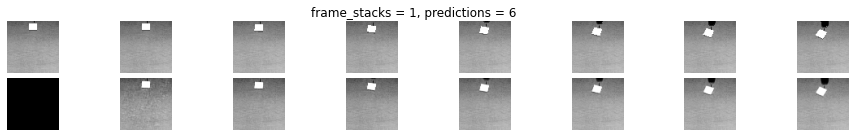

MSE of predictions:  [4.6255126 1.9689115 2.963748  4.07819   2.6401367 3.3780532]


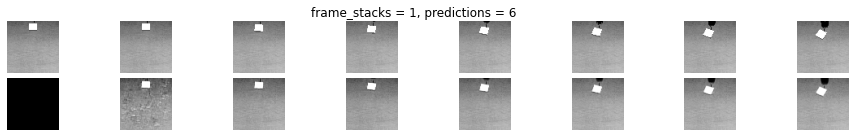

MSE of predictions:  [3.9501126 2.4108593 3.4154146 3.4810603 3.2977753 3.7595966]


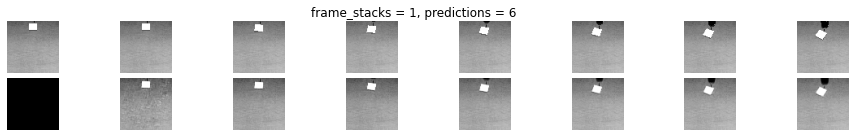

MSE of predictions:  [1.5743355 1.1798348 2.9031842 2.7617016 4.1911244 4.478913 ]


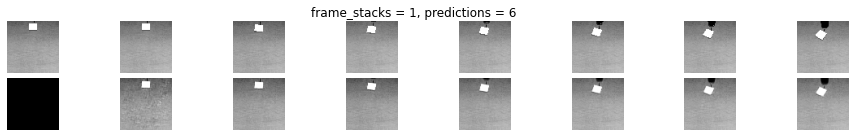

In [27]:
dict_of_models = {}

# Load hyperparameters from trained model
for filedir in os.listdir(args.models_dir):
    fullpath = os.path.join(args.models_dir, filedir)
    if os.path.isdir(fullpath):
        with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
            dict_of_models[fullpath] = Namespace(**json.load(fp))

with torch.no_grad():
    for path, hyperparams in dict_of_models.items():
        model_args = hyperparams
        if model_args.dim_x[0] == 1:
            imgs = imgs_gray
        elif model_args.dim_x[0] == 3:
            imgs = imgs_rgb
        ii = np.random.randint(imgs.shape[0] // args.n_examples)
        total_len = imgs.shape[1]
        T = model_args.frame_stacks
        start_idx = np.random.randint(total_len - args.n_predictions - T)

        u_f = actions[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            (T + 1):(T + 1 + args.n_predictions)
        ] 
        
        x = imgs[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            :(T + 1 + args.n_predictions)
        ]
        x_i = imgs[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            :(T + 1)
        ] 
        x_i = frame_stack(x_i, frames=T)  

        x_ft = ft[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            :(T + 1 + args.n_predictions)
        ]
        x_ft_i = ft[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            T:(T + 1)
        ]

        x_arm = arm[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            :(T + 1 + args.n_predictions)
        ]
        x_arm_i = arm[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            T:(T + 1)
        ]

        models = load_vh_models(path, model_args, mode='eval', device=args.device)
        
        # Roll-out or predictions
        z_all = []
        if model_args.use_img_enc:
            z_all.append(models["img_enc"](x_i.reshape(-1, *x_i.shape[2:])))

        if model_args.use_joint_enc:
            joint_inp = torch.cat((
                x_ft_i.reshape(-1, *x_ft_i.shape[2:]), 
                x_arm_i.reshape(-1, *x_arm_i.shape[2:])), 
                dim=-1
            )
            z_all.append(models["joint_enc"](joint_inp)[:, -1])
        else:
            if model_args.use_haptic_enc:
                z_all.append(models["haptic_enc"](x_ft_i.reshape(-1, *x_ft_i.shape[2:]))[:, -1])
            if model_args.use_arm_enc:
                z_all.append(models["arm_enc"](x_arm_i.reshape(-1, *x_arm_i.shape[2:]))[:, -1])
            
        z_cat_i = torch.cat(z_all, dim=1)
        z_i, mu_z_i, logvar_z_i = models["mix"](z_cat_i)
        var_z_i = torch.diag_embed(torch.exp(logvar_z_i))
        h_i = None

        z_hat = torch.zeros((args.n_examples, (1 + args.n_predictions), model_args.dim_z)).to(device=args.device)
        z_hat[:, 0] = z_i

        for jj in range(args.n_predictions):
            z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = models["dyn"](
                z_t=z_i, 
                mu_t=mu_z_i, 
                var_t=var_z_i, 
                u=u_f[:, jj], 
                h=h_i, 
                single=True
            )

            z_hat[:, jj + 1] = mu_z_ip1
            z_i, mu_z_i, var_z_i, h_i = z_ip1, mu_z_ip1, var_z_ip1, h_ip1    
        
        # Decode predictions
        x_hat = models["img_dec"](z_hat.reshape(-1, *z_hat.shape[2:]))
        x_hat = x_hat.reshape(args.n_examples, (args.n_predictions + 1), *x_hat.shape[1:])
            
        # Move to cpu, np
        x_hat = x_hat.cpu().numpy()
        x = x.cpu().numpy()
        
        mse = np.sum((x_hat[:, 1:, 0].reshape(args.n_examples, args.n_predictions, -1) - 
                      x[:, 2:, 0].reshape(args.n_examples, args.n_predictions, -1))**2, axis=2)

        # Plotting
        for bb in range(args.n_examples):
            columns = T + 1 + args.n_predictions
            rows = 2
            fig=plt.figure(figsize=(16, 2))
            fig.suptitle('frame_stacks = {}, predictions = {}'.format(T, args.n_predictions))
            for ii in range(columns*rows):
                if ii<((columns*rows)/2):
                    img = x[bb,ii,0,:,:]
                else:
                    idx = int(ii-((columns*rows)/2))
                    if idx < T:
                        img = np.zeros((model_args.dim_x[1], model_args.dim_x[2]))
                    else:
                        img = x_hat[bb,idx-1,0,:,:]
                fig.add_subplot(rows, columns, ii+1)
                plt.imshow(img, cmap="gray")
                
                plt.axis('off')
            print("MSE of predictions: ", mse[bb])
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            plt.show()